### CASA0002_Urban simulation
# Part 1 Assignment: London tube network analysis
---


April 2024



## Introduction: Constructing the networks

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter

import numpy as np
import geopandas as gpd
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

# Load the network data
G = nx.read_graphml('/Users/victoriachen/Documents/Simulation/Assessment/london.graph.xml')
# Load the flow data
flows = pd.read_csv('/Users/victoriachen/Documents/Simulation/Assessment/london_flows.csv')


print("Number of stations (nodes):", G.number_of_nodes())
print("Number of connections (edges):", G.number_of_edges())


print(flows.head())


Number of stations (nodes): 401
Number of connections (edges): 467
  station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167


In [4]:
type(G)

networkx.classes.graph.Graph

In [5]:
# list all operations of the G object
print(len(dir(G)))
for i in np.random.randint(0, len(dir(G)), 10):
    print(dir(G)[i])

75
size
edge_attr_dict_factory
to_directed
edge_subgraph
add_node
__getattribute__
degree
remove_node
edges
number_of_nodes


In [6]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [7]:
#convert tcoords tuples back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [8]:
# To check node attributes:
list(G.nodes(data = True))[0]


('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [9]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [10]:

for node, data in G.nodes(data=True):
    # Add the 'station_name' key 
    data['station_name'] = node

print(list(G.nodes(data=True))[0])

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672), 'station_name': 'Wembley Park'})


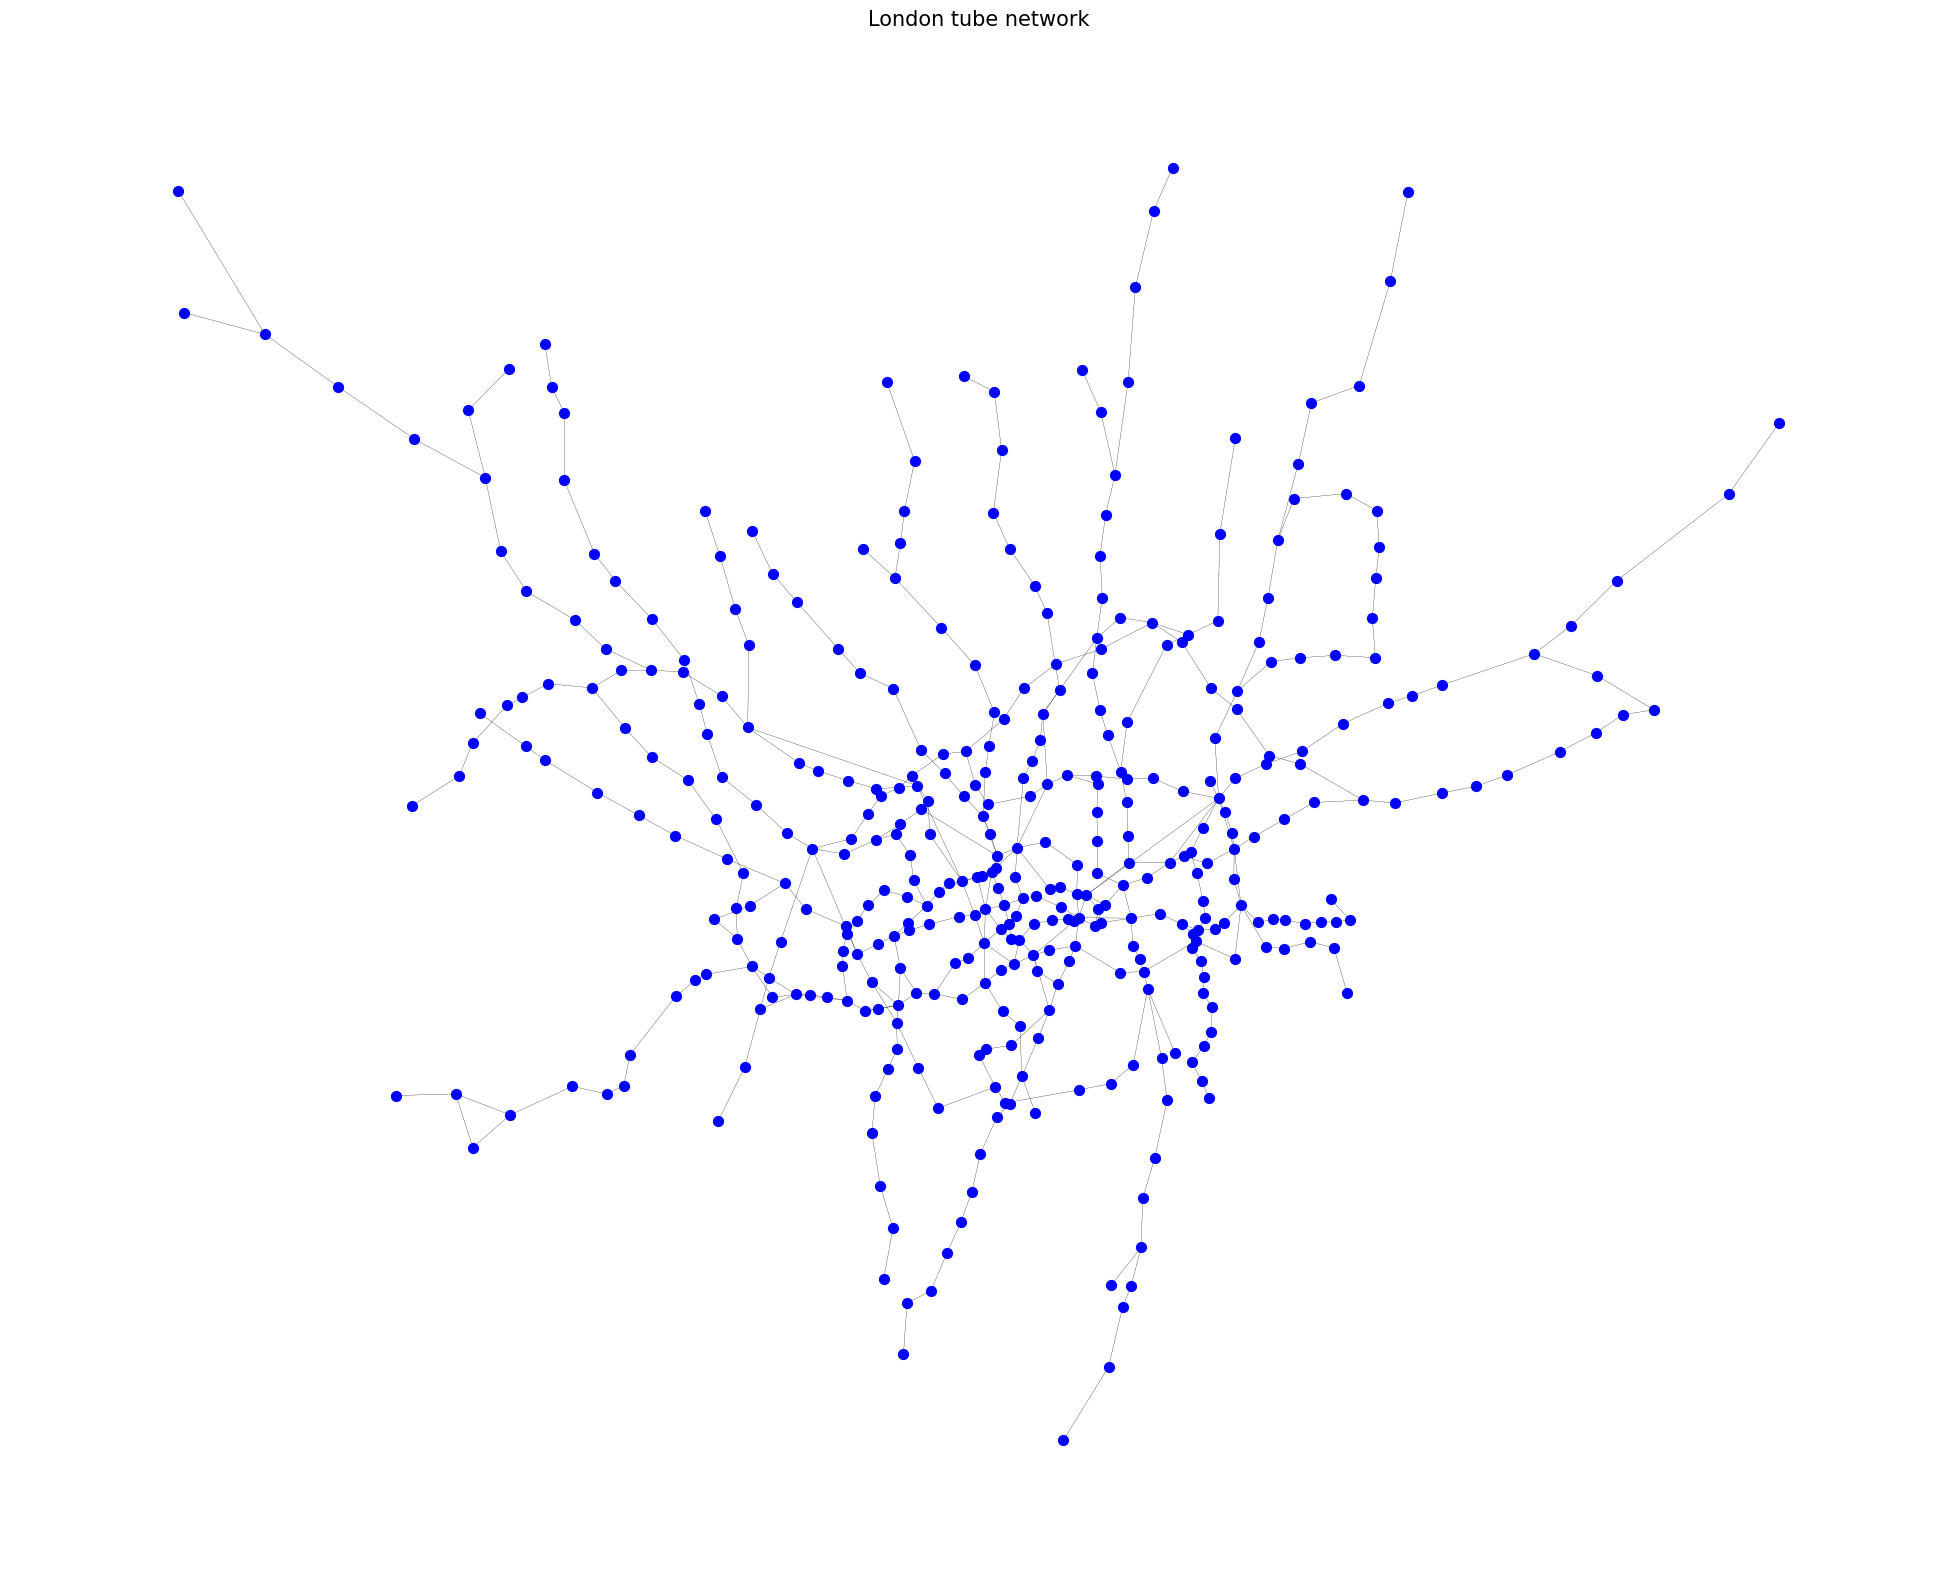

In [11]:
# plot the tube network

fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'node')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='blue')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()


In [12]:
 #We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(G)
df[0:10]

,source,target,flows,length,line_name
0,Wembley Park,Kingsbury,12356,2916.771558,Jubilee
1,Wembley Park,Neasden,6744,2353.165938,Jubilee
2,Wembley Park,Preston Road,36601,1419.735166,Metropolitan
3,Wembley Park,Finchley Road,55216,7266.373927,Metropolitan
4,Kingsbury,Queensbury,9419,1245.995234,Jubilee
5,Queensbury,Canons Park,6385,1693.307343,Jubilee
6,Canons Park,Stanmore,3624,1419.669476,Jubilee
7,Stratford,West Ham,91801,1673.509515,Jubilee
8,Stratford,Mile End,12010,2805.001392,Central
9,Stratford,Leyton,56082,2131.342926,Central


## 3.  Part 1. Tube Resilience

#### I.1.1. Centrality measures: Degree Centrality

In [13]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [14]:
# To dataframe using the nodes as the index
df_degree = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_degree['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_degree_s = df_degree.sort_values(["degree"], ascending=False)


print(df_degree_s[0:10])

d_nodes = df_degree_s.head(10)
d_nodes = d_nodes.index.tolist()
d_nodes

                          degree
Stratford                 0.0225
Bank and Monument         0.0200
King's Cross St. Pancras  0.0175
Baker Street              0.0175
Earl's Court              0.0150
Oxford Circus             0.0150
Liverpool Street          0.0150
Waterloo                  0.0150
Green Park                0.0150
Canning Town              0.0150


['Stratford',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Baker Street',
 "Earl's Court",
 'Oxford Circus',
 'Liverpool Street',
 'Waterloo',
 'Green Park',
 'Canning Town']

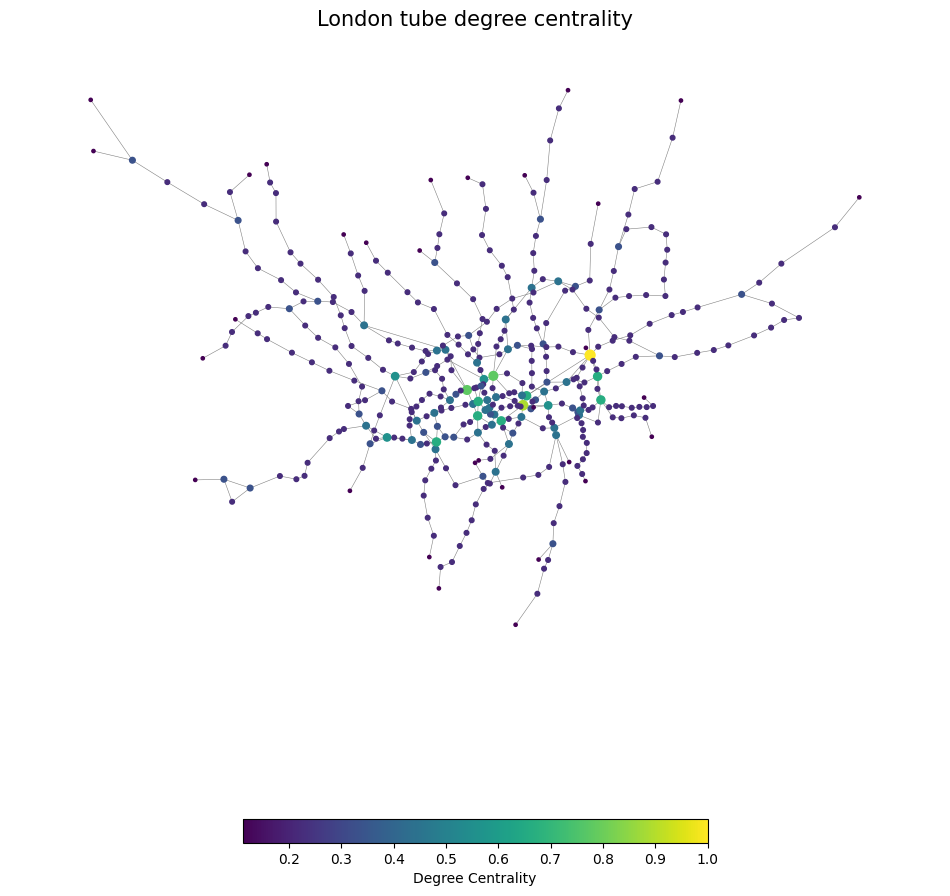

In [15]:
# set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

#### I.1.2. Centrality measures: Betweenness Centrality

In [16]:
bet_london_w=nx.betweenness_centrality(G,weight='length',normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_w,'betweenness_w')

In [17]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

# To ataframe using the nodes as the index
df_betweenness_t = pd.DataFrame(index=G.nodes())
df_betweenness_t['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_betweenness_t['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_betweenness_t_s = df_betweenness_t.sort_values(["betweenness_t"], ascending=False)
print(df_betweenness_t_s[0:10])

b_nodes = df_betweenness_t_s.head(10)
b_nodes = b_nodes.index.tolist()
b_nodes

                                      station_name  betweenness_t
Stratford                                Stratford   23768.093434
Bank and Monument                Bank and Monument   23181.058947
Liverpool Street                  Liverpool Street   21610.387049
King's Cross St. Pancras  King's Cross St. Pancras   20373.521465
Waterloo                                  Waterloo   19464.882323
Green Park                              Green Park   17223.622114
Euston                                      Euston   16624.275469
Westminster                            Westminster   16226.155916
Baker Street                          Baker Street   15287.107612
Finchley Road                        Finchley Road   13173.758009


['Stratford',
 'Bank and Monument',
 'Liverpool Street',
 "King's Cross St. Pancras",
 'Waterloo',
 'Green Park',
 'Euston',
 'Westminster',
 'Baker Street',
 'Finchley Road']

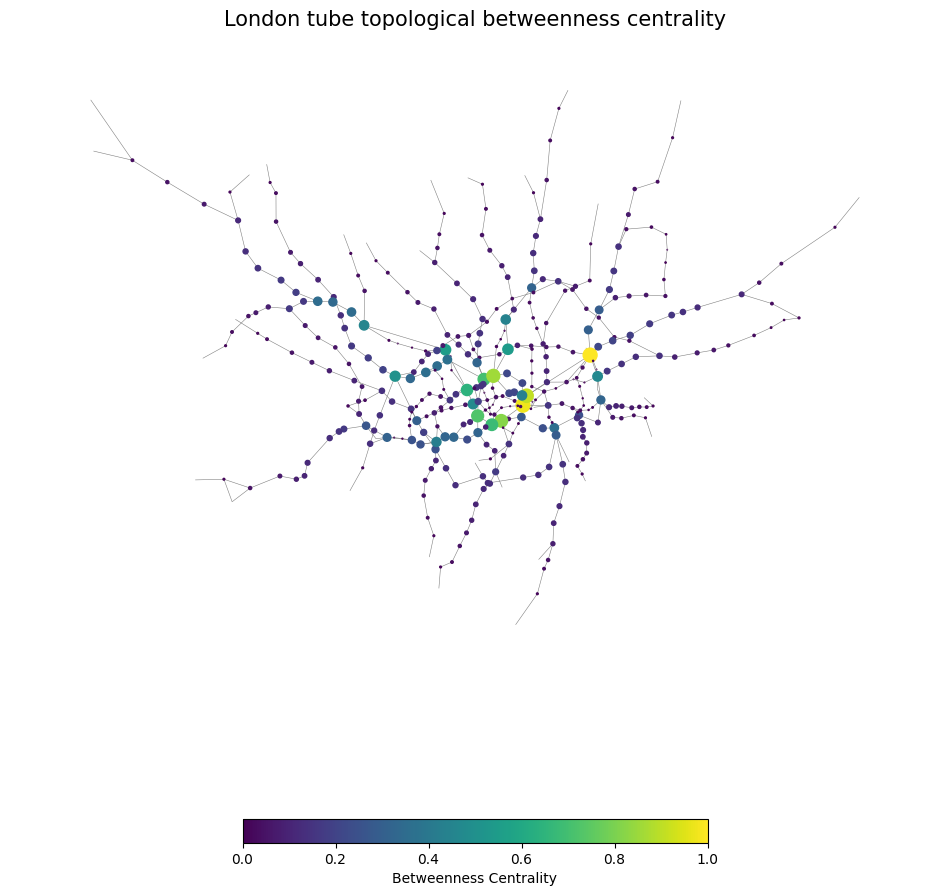

In [18]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

#### Betweenness Centrality on the edges:

#### I.1.2. Centrality measures: Closeness Centrality

In [19]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df_closeness_t = pd.DataFrame(index=G.nodes())
df_closeness_t['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_closeness_t_s = df_closeness_t.sort_values(["closeness_t"], ascending=False)
print(df_closeness_t_s[0:10])

c_nodes = df_closeness_t_s.head(10)
c_nodes = c_nodes.index.tolist()
c_nodes

                          closeness_t
Green Park                   0.114778
Bank and Monument            0.113572
King's Cross St. Pancras     0.113443
Westminster                  0.112549
Waterloo                     0.112265
Oxford Circus                0.111204
Bond Street                  0.110988
Farringdon                   0.110742
Angel                        0.110742
Moorgate                     0.110314


['Green Park',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Westminster',
 'Waterloo',
 'Oxford Circus',
 'Bond Street',
 'Farringdon',
 'Angel',
 'Moorgate']

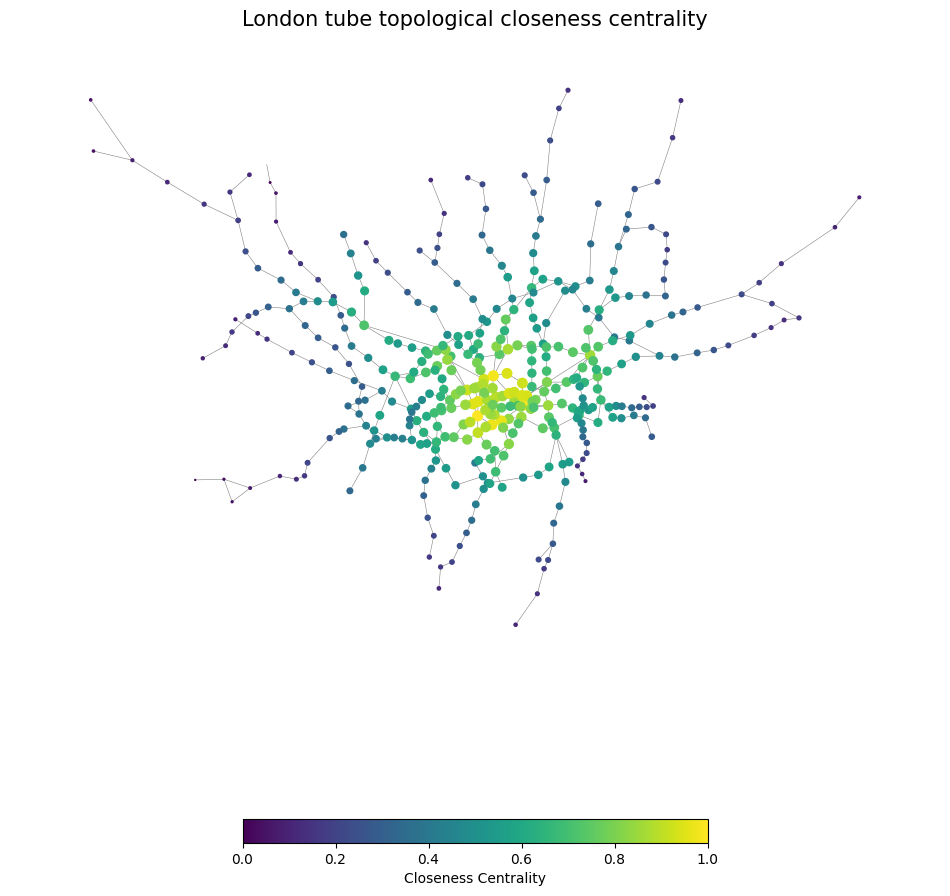

In [20]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

In [21]:
# number of connected components
nx.number_connected_components(G)

1

### I.3.1. Non-sequential node removal


In [22]:
G1=G.copy()


In [23]:
print(type(G1))

<class 'networkx.classes.graph.Graph'>


In [24]:
print(G1.nodes())

['Wembley Park', 'Kingsbury', 'Queensbury', 'Canons Park', 'Stanmore', 'Stratford', 'West Ham', 'Canning Town', 'North Greenwich', 'Canary Wharf', 'Canada Water', 'Bermondsey', 'London Bridge', 'Southwark', 'Waterloo', 'Westminster', 'Green Park', 'Bond Street', 'Baker Street', "St. John's Wood", 'Swiss Cottage', 'Finchley Road', 'Neasden', 'Dollis Hill', 'Willesden Green', 'Kilburn', 'West Hampstead', 'West Acton', 'Ealing Broadway', 'North Acton', 'West Ruislip', 'Ruislip Gardens', 'South Ruislip', 'Northolt', 'Greenford', 'Perivale', 'Hanger Lane', 'East Acton', 'White City', "Shepherd's Bush", 'Holland Park', 'Notting Hill Gate', 'Queensway', 'Lancaster Gate', 'Marble Arch', 'Oxford Circus', 'Tottenham Court Road', 'Holborn', 'Chancery Lane', "St. Paul's", 'Bank and Monument', 'Liverpool Street', 'Bethnal Green', 'Mile End', 'Leyton', 'Leytonstone', 'Snaresbrook', 'South Woodford', 'Woodford', 'Buckhurst Hill', 'Loughton', 'Debden', 'Theydon Bois', 'Epping', 'Wanstead', 'Redbridge'

## evaluate the impact of the removal using the two measures

### Non-sequential, Eglob

In [26]:
G1 = G.copy()

In [38]:
results_non_sequential_Eg = []

In [39]:
for cent, nodes in [('degree', d_nodes), ('betweenness_t', b_nodes), ('closeness_t', c_nodes)]:
    print(f"Removing nodes by {cent} centrality with no iteration, Eglob:")
    
    G1_copy = G1.copy() 
    for i in range(10):
        node_to_remove = nodes[i]
        if node_to_remove in G1_copy.nodes:
            G1_copy.remove_node(node_to_remove)
            ge = nx.global_efficiency(G1_copy)
            print(f"Removed node {node_to_remove}, Eglob: {ge:.3f}")
            results_non_sequential_Eg.append((cent, i+1, ge))
        else:
            print(f"Node {node_to_remove} is not in the graph.")

Removing nodes by degree centrality with no iteration, Eglob:
Removed node Stratford, Eglob: 0.089
Removed node Bank and Monument, Eglob: 0.086
Removed node King's Cross St. Pancras, Eglob: 0.080
Removed node Baker Street, Eglob: 0.076
Removed node Earl's Court, Eglob: 0.074
Removed node Oxford Circus, Eglob: 0.073
Removed node Liverpool Street, Eglob: 0.071
Removed node Waterloo, Eglob: 0.069
Removed node Green Park, Eglob: 0.068
Removed node Canning Town, Eglob: 0.063
Removing nodes by betweenness_t centrality with no iteration, Eglob:
Removed node Stratford, Eglob: 0.089
Removed node Bank and Monument, Eglob: 0.086
Removed node Liverpool Street, Eglob: 0.085
Removed node King's Cross St. Pancras, Eglob: 0.078
Removed node Waterloo, Eglob: 0.076
Removed node Green Park, Eglob: 0.074
Removed node Euston, Eglob: 0.068
Removed node Westminster, Eglob: 0.068
Removed node Baker Street, Eglob: 0.065
Removed node Finchley Road, Eglob: 0.063
Removing nodes by closeness_t centrality with no i

### Non-sequential, average shortest path

In [40]:
results_non_sequential_shortest = []

for cent, nodes in [('degree', d_nodes), ('betweenness_t', b_nodes), ('closeness_t', c_nodes)]:
    print(f"Removing nodes by {cent} centrality, with no iteration, average shortest path:")
    G1_copy = G1.copy() 
    
    for i in range(10):
        node_to_remove = nodes[i]
        G1_copy.remove_node(node_to_remove)
        largest_connected_component = max(nx.connected_components(G1_copy), key=len)
        subgraph = G1_copy.subgraph(largest_connected_component)
        aspl = nx.average_shortest_path_length(subgraph)
        print(f"Removed node {node_to_remove}, ASPL: {aspl:.3f}")
        results_non_sequential_shortest.append((cent, i+1, aspl))


Removing nodes by degree centrality, with no iteration, average shortest path:
Removed node Stratford, ASPL: 14.496
Removed node Bank and Monument, ASPL: 14.872
Removed node King's Cross St. Pancras, ASPL: 16.055
Removed node Baker Street, ASPL: 17.013
Removed node Earl's Court, ASPL: 17.376
Removed node Oxford Circus, ASPL: 17.557
Removed node Liverpool Street, ASPL: 17.562
Removed node Waterloo, ASPL: 18.185
Removed node Green Park, ASPL: 18.325
Removed node Canning Town, ASPL: 18.570
Removing nodes by betweenness_t centrality, with no iteration, average shortest path:
Removed node Stratford, ASPL: 14.496
Removed node Bank and Monument, ASPL: 14.872
Removed node Liverpool Street, ASPL: 15.031
Removed node King's Cross St. Pancras, ASPL: 16.031
Removed node Waterloo, ASPL: 16.757
Removed node Green Park, ASPL: 17.181
Removed node Euston, ASPL: 16.807
Removed node Westminster, ASPL: 16.975
Removed node Baker Street, ASPL: 17.586
Removed node Finchley Road, ASPL: 17.987
Removing nodes b

### sequential, Eglob

In [41]:
results_sequential_EG = []

for cent in ['degree', 'betweenness_t', 'closeness_t']:
    print(f"Removing nodes by {cent} centrality sequentially, sequential, Eglob:")
    
    G1_copy = G1.copy()   
    
    for i in range(10):
        if cent == 'degree':
            centrality = nx.degree_centrality(G1_copy)
        elif cent == 'betweenness_t':
            centrality = nx.betweenness_centrality(G1_copy)
        else:  
            centrality = nx.closeness_centrality(G1_copy)
        
        node_to_remove = max(centrality, key=centrality.get)
        
        G1_copy.remove_node(node_to_remove)
        ge = nx.global_efficiency(G1_copy)
        print(f"Removed node {node_to_remove},  GE: {ge:.3f}")
        results_sequential_EG.append((cent, i+1, ge))

Removing nodes by degree centrality sequentially, sequential, Eglob:
Removed node Stratford,  GE: 0.089
Removed node Bank and Monument,  GE: 0.086
Removed node Baker Street,  GE: 0.082
Removed node King's Cross St. Pancras,  GE: 0.076
Removed node Canning Town,  GE: 0.070
Removed node Green Park,  GE: 0.069
Removed node Earl's Court,  GE: 0.068
Removed node Waterloo,  GE: 0.066
Removed node Oxford Circus,  GE: 0.065
Removed node Willesden Junction,  GE: 0.057
Removing nodes by betweenness_t centrality sequentially, sequential, Eglob:
Removed node Stratford,  GE: 0.089
Removed node King's Cross St. Pancras,  GE: 0.085
Removed node Waterloo,  GE: 0.082
Removed node Bank and Monument,  GE: 0.078
Removed node Canada Water,  GE: 0.073
Removed node West Hampstead,  GE: 0.053
Removed node Earl's Court,  GE: 0.052
Removed node Shepherd's Bush,  GE: 0.046
Removed node Euston,  GE: 0.042
Removed node Baker Street,  GE: 0.038
Removing nodes by closeness_t centrality sequentially, sequential, Eglo

### sequential, shortest path

In [42]:

results_sequential_shortest = []

for cent in ['degree', 'betweenness_t', 'closeness_t']:
    print(f"Removing nodes by {cent} centrality, sequential,for average shorest path :")
    
    G1_copy = G1.copy()
    
    for i in range(10):
        if cent == 'degree':
            centrality = nx.degree_centrality(G1_copy)
        elif cent == 'betweenness_t':
            centrality = nx.betweenness_centrality(G1_copy)
        else:  # closeness_t
            centrality = nx.closeness_centrality(G1_copy)
        
        node_to_remove = max(centrality, key=centrality.get)
        
        G1_copy.remove_node(node_to_remove)
        
        largest_connected_component = max(nx.connected_components(G1_copy), key=len)
        subgraph = G1_copy.subgraph(largest_connected_component)
        
        aspl = nx.average_shortest_path_length(subgraph)
        #ge = nx.global_efficiency(G_new)
        
        print(f"Removed node {node_to_remove}, ASPL: {aspl:.3f}")
        #print(f"Removed node {node_to_remove},  GE: {ge:.3f}")
        
        results_sequential_shortest.append((cent, i+1, aspl))
        

Removing nodes by degree centrality, sequential,for average shorest path :
Removed node Stratford, ASPL: 14.496
Removed node Bank and Monument, ASPL: 14.872
Removed node Baker Street, ASPL: 15.686
Removed node King's Cross St. Pancras, ASPL: 17.013
Removed node Canning Town, ASPL: 17.376
Removed node Green Park, ASPL: 17.531
Removed node Earl's Court, ASPL: 17.895
Removed node Waterloo, ASPL: 18.494
Removed node Oxford Circus, ASPL: 18.575
Removed node Willesden Junction, ASPL: 21.207
Removing nodes by betweenness_t centrality, sequential,for average shorest path :
Removed node Stratford, ASPL: 14.496
Removed node King's Cross St. Pancras, ASPL: 15.310
Removed node Waterloo, ASPL: 15.796
Removed node Bank and Monument, ASPL: 16.790
Removed node Canada Water, ASPL: 19.029
Removed node West Hampstead, ASPL: 13.462
Removed node Earl's Court, ASPL: 14.206
Removed node Shepherd's Bush, ASPL: 13.792
Removed node Euston, ASPL: 13.822
Removed node Baker Street, ASPL: 18.194
Removing nodes by c

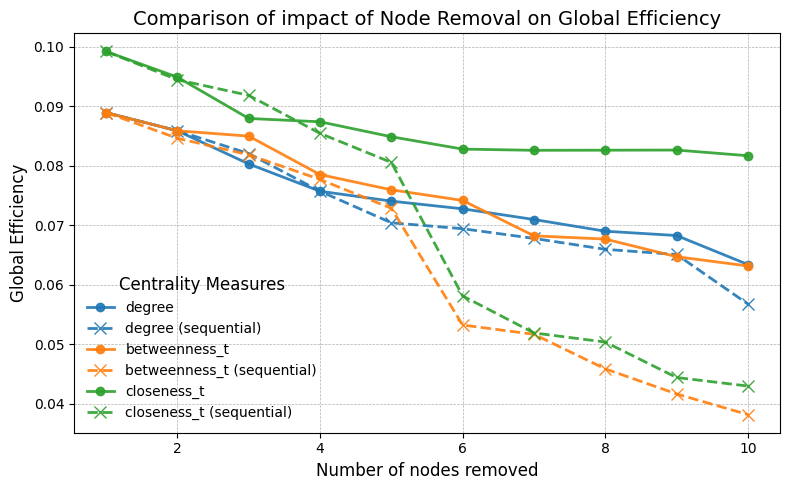

In [53]:
import matplotlib.pyplot as plt

# Use (Tableau 10)
colors = {'degree': '#1f77b4',  # Blue
          'betweenness_t': '#ff7f0e',  # Orange
          'closeness_t': '#2ca02c'}  # Green

line_styles = {'non_sequential': '-', 'sequential': '--'}


plt.figure(figsize=(8, 5))

for cent in ['degree', 'betweenness_t', 'closeness_t']:
    # Data for non-sequential and sequential removal
    data_nonseq_eg = [r for r in results_non_sequential_Eg if r[0] == cent]
    data_seq_shortest = [r for r in results_sequential_EG if r[0] == cent]
    
    # Plot non-sequential data
    plt.plot([r[1] for r in data_nonseq_eg], [r[2] for r in data_nonseq_eg], 
             linestyle=line_styles['non_sequential'], color=colors[cent], 
             marker='o', markersize=6, linewidth=2, alpha=0.9, label=cent)
    
    # Plot sequential data
    plt.plot([r[1] for r in data_seq_shortest], [r[2] for r in data_seq_shortest], 
             linestyle=line_styles['sequential'], color=colors[cent], 
             marker='x', markersize=8, linewidth=2, alpha=0.9, label=cent+' (sequential)')

# Labels and Title
plt.xlabel('Number of nodes removed', fontsize=12)
plt.ylabel('Global Efficiency', fontsize=12)
plt.title('Comparison of impact of Node Removal on Global Efficiency', fontsize=14)

# Customize Legend - Move to bottom left
plt.legend(title='Centrality Measures', loc='lower left', fontsize=10, title_fontsize='12', frameon=False)

# Grid and Layout
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save and Show Plot
plt.savefig('GE.png', dpi=300, bbox_inches='tight')
plt.show()


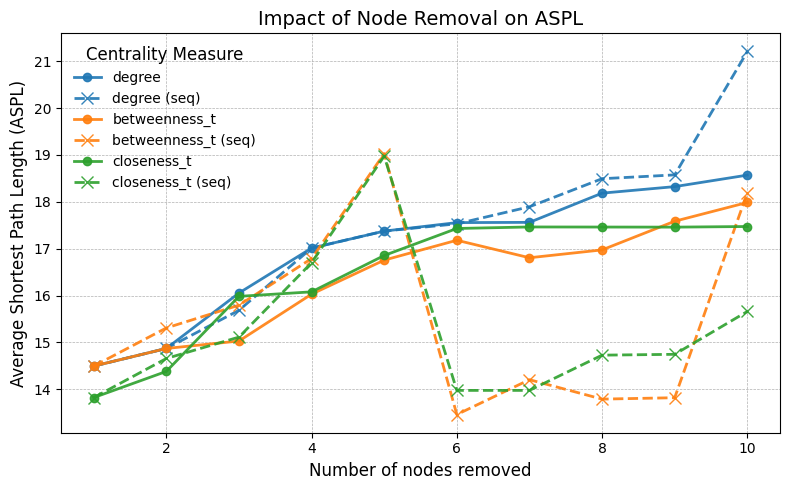

In [59]:
import matplotlib.pyplot as plt

colors = {'degree': '#1f77b4',  # Blue
          'betweenness_t': '#ff7f0e',  # Orange
          'closeness_t': '#2ca02c'}  # Green

line_styles = {'non_seq': '-', 'seq': '--'}

# Create the plot
plt.figure(figsize=(8, 5))

for cent in ['degree', 'betweenness_t', 'closeness_t']:
    # Data for non-sequential and sequential removal
    data_nonseq_shortest = [r for r in results_non_sequential_shortest if r[0] == cent]
    data_seq_shortest = [r for r in results_sequential_shortest if r[0] == cent]
    
    # Plot non-sequential data (B)
    plt.plot([r[1] for r in data_nonseq_shortest], [r[2] for r in data_nonseq_shortest], 
             linestyle=line_styles['non_seq'], color=colors[cent], 
             marker='o', markersize=6, linewidth=2, alpha=0.9, label=cent)
    
    # Plot sequential data (D)
    plt.plot([r[1] for r in data_seq_shortest], [r[2] for r in data_seq_shortest], 
             linestyle=line_styles['seq'], color=colors[cent], 
             marker='x', markersize=8, linewidth=2, alpha=0.9, label=cent+' (seq)')

# Labels and Title
plt.xlabel('Number of nodes removed', fontsize=12)
plt.ylabel('Average Shortest Path Length (ASPL)', fontsize=12)
plt.title('Impact of Node Removal on ASPL', fontsize=14)

# Customize Legend - Move to bottom left
plt.legend(title='Centrality Measure', loc='upper left', fontsize=10, title_fontsize='12', frameon=False)

# Grid and Layout
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save and Show Plot
plt.savefig('ASPL.png', dpi=300, bbox_inches='tight')
plt.show()


# Flows: Weighted Netwrok. Evaluate if different measures need to be used when consider flow

# Flows: Weighted Netwrok. Evaluate if different measures need to be used when consider flow

In [77]:
G

In [78]:
#We can print the dataframe from the shapefile to check the data
df_G = nx.to_pandas_edgelist(G)
df_G[0:10]

,source,target,flows,length,line_name
0,Wembley Park,Kingsbury,12356,2916.771558,Jubilee
1,Wembley Park,Neasden,6744,2353.165938,Jubilee
2,Wembley Park,Preston Road,36601,1419.735166,Metropolitan
3,Wembley Park,Finchley Road,55216,7266.373927,Metropolitan
4,Kingsbury,Queensbury,9419,1245.995234,Jubilee
5,Queensbury,Canons Park,6385,1693.307343,Jubilee
6,Canons Park,Stanmore,3624,1419.669476,Jubilee
7,Stratford,West Ham,91801,1673.509515,Jubilee
8,Stratford,Mile End,12010,2805.001392,Central
9,Stratford,Leyton,56082,2131.342926,Central


In [80]:
df_G_flows = df_G.sort_values(["flows"], ascending=False)
df_G_flows[0:10]

,source,target,flows,length,line_name
38,Waterloo,Westminster,219499,850.360026,Jubilee
42,Waterloo,Bank and Monument,216157,2542.954444,Waterloo & City
43,Westminster,Green Park,189976,1423.780195,Jubilee
103,Bank and Monument,Liverpool Street,160401,841.502684,Central
14,Stratford,Liverpool Street,146148,6698.461270,TfL Rail
46,Green Park,Bond Street,140801,1148.912313,Jubilee
232,Euston,King's Cross St. Pancras,132144,863.369674,Victoria
50,Green Park,Oxford Circus,125407,1010.566475,Victoria
49,Green Park,Victoria,121521,1209.599809,Victoria
196,Highbury & Islington,King's Cross St. Pancras,120037,2581.853010,Victoria


In [82]:
Weighted_betweenness_s = nx.betweenness_centrality(G, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'), normalized=False)

# We can add these values to the nodes attributes:

nx.set_node_attributes(G,Weighted_betweenness_s,'betweenness_weighted')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_weighted'] = pd.Series(nx.get_node_attributes(G, 'betweenness_weighted'))

Weighted_betweenness_s = df.sort_values(["betweenness_weighted"], ascending=False)
Weighted_betweenness_s = Weighted_betweenness_s.reset_index(drop=True)
Weighted_betweenness_s[0:10]

,station_name,betweenness_weighted
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
5,Liverpool Street,26848.579108
6,Bond Street,23188.980459
7,Euston,22600.517152
8,Oxford Circus,21453.463388
9,Warren Street,20140.612103


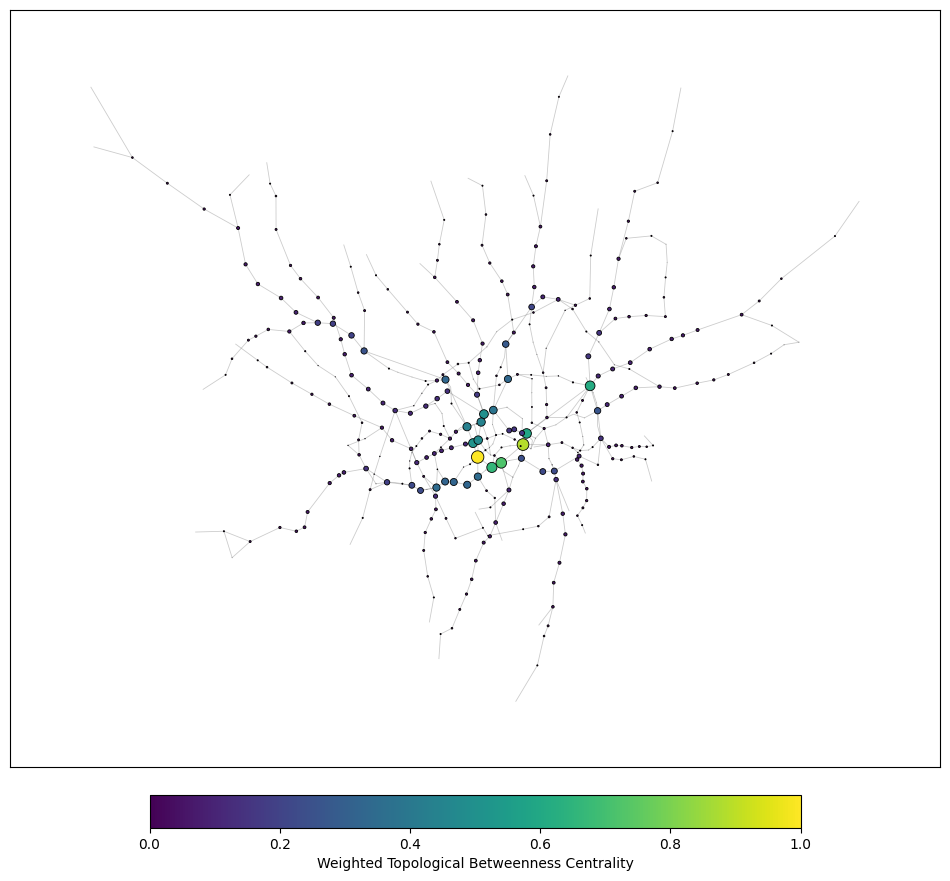

In [89]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Get betweenness values
betweenness_weighted_values = [i[1]['betweenness_weighted'] for i in G.nodes(data=True)]

# Normalize betweenness values for colors and sizes
bet_w_color = [(i[1]['betweenness_weighted'] / max(betweenness_weighted_values)) for i in G.nodes(data=True)]
bet_w_size = [(i[1]['betweenness_weighted'] / max(betweenness_weighted_values)) * 80 for i in G.nodes(data=True)]  # Adjusted scaling for better visibility

# Define graph position
pos = pos

# Create the plot
fig, ax = plt.subplots(figsize=(12,12))

# Draw edges with slight transparency for better readability
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.6, alpha=0.4)

# Draw nodes with colormap and adjusted sizes
nod = nx.draw_networkx_nodes(
    G, 
    pos=pos, 
    node_color=bet_w_color, 
    node_size=bet_w_size, 
    cmap=cm.viridis,  # Using viridis for better contrast and visibility
    edgecolors='black',  # Adding black edges to the nodes for clarity
    linewidths=0.6
)

# Add a color bar for betweenness centrality
plt.colorbar(nod, label="Weighted Topological Betweenness Centrality", orientation="horizontal", pad=0.03, shrink=0.7)

# Remove axes and set title


In [88]:
# Calculate weighted closeness centrality using the inverted flows as the distance
# Avoid using an overly large uniform value for zero flows; instead, skip zero flow edges
Weighted_closeness_s = nx.closeness_centrality(G, distance=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else None)

# Add these values to the nodes attributes
nx.set_node_attributes(G, Weighted_closeness_s, 'closeness_weighted')

# Create a DataFrame using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_weighted'] = pd.Series(nx.get_node_attributes(G, 'closeness_weighted'))

# Sort the DataFrame by closeness centrality in descending order
Weighted_closeness_s = df.sort_values(["closeness_weighted"], ascending=False)

# Reset the index and display the top 10 stations
Weighted_closeness_s = Weighted_closeness_s.reset_index(drop=True)
top_10_closeness = Weighted_closeness_s[0:10]

# Display the top 10 stations by weighted closeness centrality
top_10_closeness


,station_name,closeness_weighted
0,Green Park,2347.133622
1,Westminster,2342.086423
2,Waterloo,2337.528796
3,Bank and Monument,2334.335879
4,Oxford Circus,2325.921152
5,Bond Street,2322.901294
6,Victoria,2315.857718
7,Liverpool Street,2315.375677
8,Warren Street,2300.755815
9,Moorgate,2295.755537


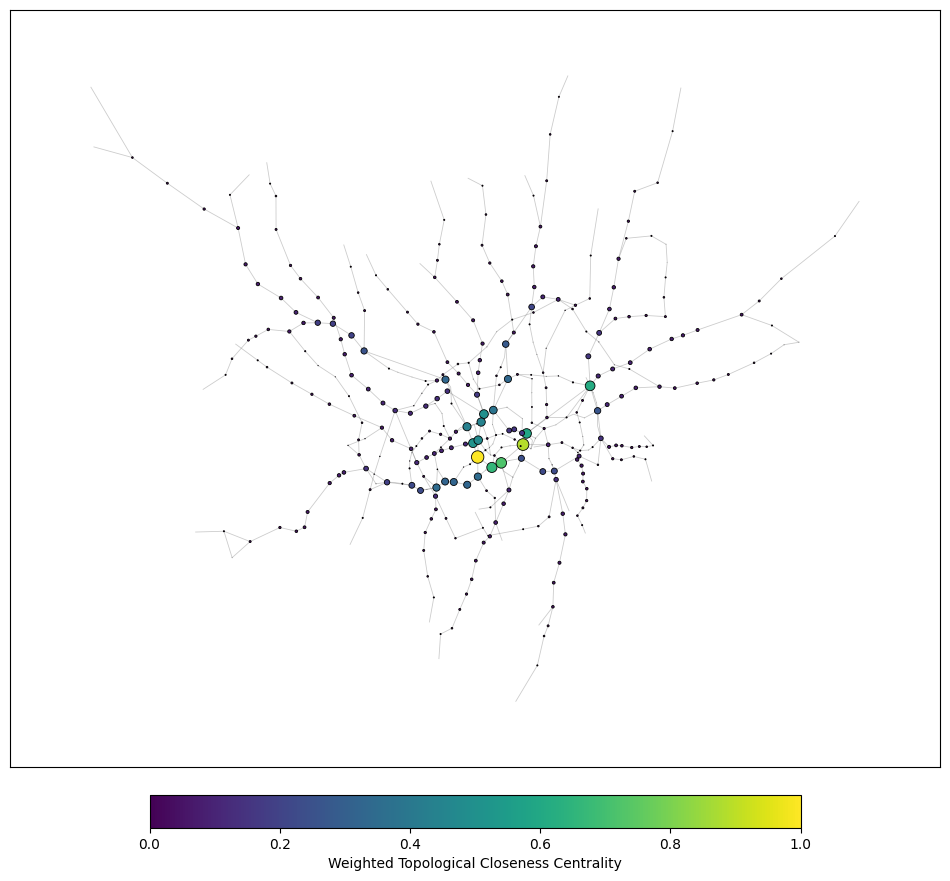

In [91]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Get betweenness values
Weighted_closeness_values = [i[1]['closeness_weighted'] for i in G.nodes(data=True)]

# Normalize betweenness values for colors and sizes
c_w_color = [(i[1]['closeness_weighted'] / max(Weighted_closeness_values)) for i in G.nodes(data=True)]
c_w_size = [(i[1]['closeness_weighted'] / max(Weighted_closeness_values)) * 80 for i in G.nodes(data=True)]  # Adjusted scaling for better visibility

# Define graph position
pos = pos

# Create the plot
fig, ax = plt.subplots(figsize=(12,12))

# Draw edges with slight transparency for better readability
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.6, alpha=0.4)

# Draw nodes with colormap and adjusted sizes
nod = nx.draw_networkx_nodes(
    G, 
    pos=pos, 
    node_color=bet_w_color, 
    node_size=bet_w_size, 
    cmap=cm.viridis,  # Using viridis for better contrast and visibility
    edgecolors='black',  # Adding black edges to the nodes for clarity
    linewidths=0.6
)

# Add a color bar for betweenness centrality
plt.colorbar(nod, label="Weighted Topological Closeness Centrality", orientation="horizontal", pad=0.03, shrink=0.7)

# Remove axes and set title


In [76]:
G2 = G.copy()

#Invert weights
for u, v, d in G2.edges(data=True):
    d['flows_i'] =  1 / (d.get('flows', 0) + .001)

betweenness_weighted_flow = nx.betweenness_centrality(G2,weight='flows_inv',normalized=True)
nx.set_node_attributes(G,betweenness_weighted_flow,'betweenness_weighted_flow')

df = pd.DataFrame(index=G2.nodes())
df['betweenness_weighted_flow'] = pd.Series(nx.get_node_attributes(G, 'betweenness_weighted_flow'))

df_sorted = df.sort_values(["betweenness_weighted_flow"], ascending=False)

betweenness_flow_top10 = df_sorted[0:10]

betweenness_flow_top10

,betweenness_weighted_flow
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


In [63]:
G3 = G.copy()

# Invert weights
for u, v, d in G3.edges(data=True):
    d['flows_inv'] = 1 / (d.get('flows', 0) + .001)

clos_w = nx.closeness_centrality(G3, distance='flows_i', wf_improved=True)
nx.set_node_attributes(G3, clos_w, 'closeness_weighted_flow')

df1 = pd.DataFrame(index=G3.nodes())
df1['closeness_weighted_flow'] = pd.Series(nx.get_node_attributes(G3, 'closeness_weighted_flow'))

df_sorted = df1.sort_values(["closeness_weighted_flow"], ascending=False)
df_sorted[0:10]

,closeness_weighted_flow
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


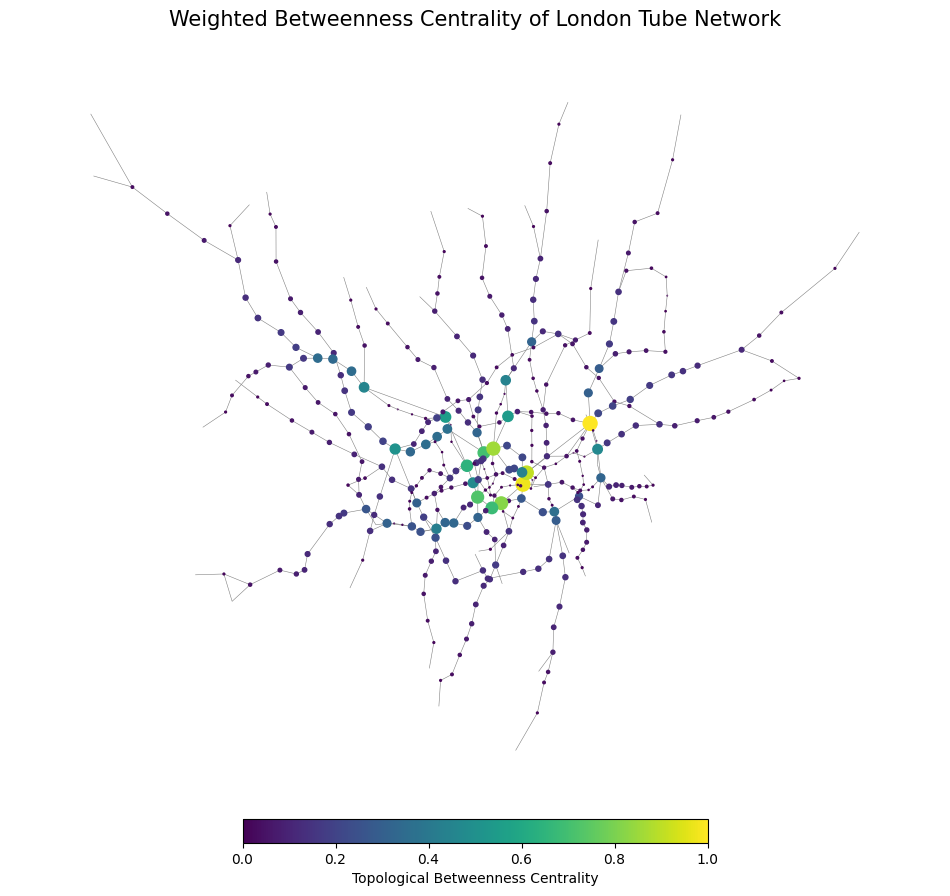

In [65]:
G3 = G.copy()

# Invert weights
for u, v, d in G3.edges(data=True):
    d['flows_inv'] = 1 / (d.get('flows', 0) + .001)

clos_w = nx.closeness_centrality(G3, distance='flows_i', wf_improved=True)
nx.set_node_attributes(G3, clos_w, 'closeness_weighted_flow')

df1 = pd.DataFrame(index=G3.nodes())
df1['closeness_weighted_flow'] = pd.Series(nx.get_node_attributes(G3, 'closeness_weighted_flow'))

df_sorted = df1.sort_values(["closeness_weighted_flow"], ascending=False)
df_sorted[0:10]

# II.2
II.2. Now consider the measure for assessing the impact of node removal. Would you adjust the measure for a weighted network? If yes, how? Propose a different measure that would be better at assessing the impact of closing a station taking into consideration the passengers.

Considering the impact of weighted networks, we should adjust the measures for assessing the impact of node removal. The definition and calculation of the LCC show that its value is independent of whether the network is weighted or not. Therefore, it doesn't have to be changed.

To improve global efficiency, we use “weighted network efficiency”. Weighted network efficiency considers the weights of paths rather than simply counting the number of paths. In such a network, when calculating the shortest path, the aim is to minimize the total weights rather than the path lengths.

In [66]:
import networkx as nx

def weighted_global_efficiency(distances, N):
    sum_inverse_distances = 0
    for i in distances:
        for j in distances[i]:
            if i != j and distances[i][j] > 0:  # 跳过自身
                sum_inverse_distances += 1 / distances[i][j]

    Eglob_weighted = sum_inverse_distances / (N * (N - 1))
    return Eglob_weighted


In [67]:
def weighted_average_shortest_path_length(distances, N):
    sum_distances = 0
    for i in distances:
        for j in distances[i]:
            if i != j and distances[i][j] > 0:  # 跳过自身
                sum_distances += distances[i][j]

    shortest_path_length_weighted = sum_distances / (N * (N - 1))
    return shortest_path_length_weighted


In [71]:
def remove_nodes_and_calculate(G, nodes_to_remove, metric_function):
    G4 = G.copy()
    results = []

    for i, node in enumerate(nodes_to_remove):
        G4.remove_node(node)

        # 获取最大连通子图
        largest_connected_component = max(nx.connected_components(G4), key=len)
        G4_new_largest_connected_component = G4.subgraph(largest_connected_component).copy()

        # 计算距离
        N = G4_new_largest_connected_component.number_of_nodes()
        if N > 1:
            distances = dict(nx.all_pairs_dijkstra_path_length(G4_new_largest_connected_component))
            metric_value = metric_function(distances, N)
        else:
            metric_value = 0  # 如果图只有一个节点或无节点，设置为0

        results.append((node, metric_value))
        print(f"Removed node {node}, metric: {metric_value:.3f}")

    return results

# 计算加权全局效率
results_weighted_global_efficiency = remove_nodes_and_calculate(G, d_nodes[:3], weighted_global_efficiency)

# 计算加权平均最短路径长度
results_weighted_average_shortest_path_length = remove_nodes_and_calculate(G, d_nodes[:3], weighted_average_shortest_path_length)


Removed node Stratford, metric: 0.098
Removed node Bank and Monument, metric: 0.095
Removed node King's Cross St. Pancras, metric: 0.089
Removed node Stratford, metric: 14.496
Removed node Bank and Monument, metric: 14.872
Removed node King's Cross St. Pancras, metric: 16.055


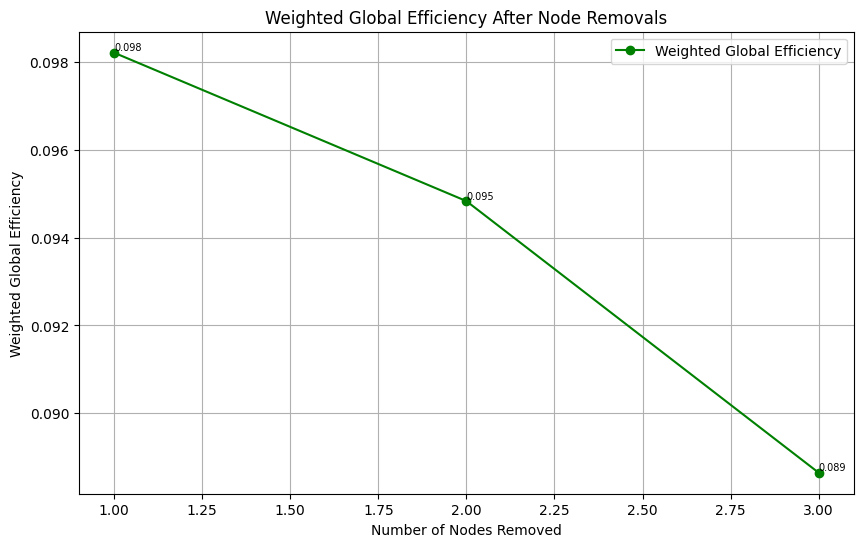

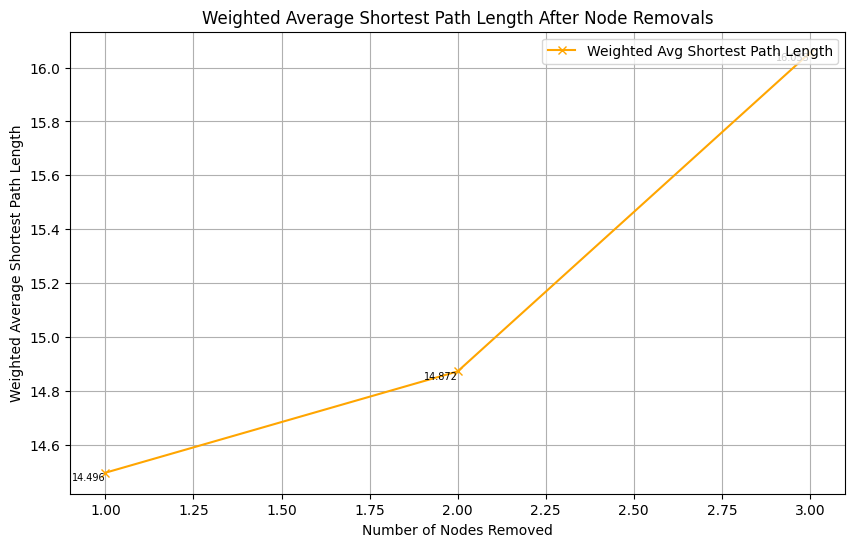

In [75]:
import matplotlib.pyplot as plt

# Assuming the results of node removals are stored in these lists:
# Example data from your results (you can replace with actual values):
removals = list(range(1, 4))  # Number of nodes removed, e.g., [1, 2, 3]
values_weighted_global_efficiency = [res[1] for res in results_weighted_global_efficiency]
values_weighted_average_shortest_path_length = [res[1] for res in results_weighted_average_shortest_path_length]

# Create the first figure for the weighted global efficiency (green)
plt.figure(figsize=(10, 6))

# Plot weighted global efficiency with green color
plt.plot(removals, values_weighted_global_efficiency, label='Weighted Global Efficiency', marker='o', color='green')

# Set title and labels
plt.title('Weighted Global Efficiency After Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Weighted Global Efficiency')

# Add gridlines to the plot
plt.grid(True)

# Annotate the points with their respective values
for i in range(len(removals)):
    plt.text(removals[i], values_weighted_global_efficiency[i], f'{values_weighted_global_efficiency[i]:.3f}', 
             ha='left', va='bottom', fontsize=7)

# Display the plot
plt.legend(loc='upper right')
plt.show()

# Create the second figure for the weighted average shortest path length (orange)
plt.figure(figsize=(10, 6))

# Plot weighted average shortest path length with orange color
plt.plot(removals, values_weighted_average_shortest_path_length, label='Weighted Avg Shortest Path Length', marker='x', color='orange')

# Set title and labels
plt.title('Weighted Average Shortest Path Length After Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Weighted Average Shortest Path Length')

# Add gridlines to the plot
plt.grid(True)

# Annotate the points with their respective values
for i in range(len(removals)):
    plt.text(removals[i], values_weighted_average_shortest_path_length[i], f'{values_weighted_average_shortest_path_length[i]:.3f}', 
             ha='right', va='top', fontsize=7)

# Display the plot
plt.legend(loc='upper right')
plt.show()


# spatial interaction model


In [92]:
data = pd.read_csv("/Users/victoriachen/Documents/Simulation/Assessment/london_flows.csv")
data.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [94]:
# define r^2 and RMSE calculations
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE